In [1]:
using PyPlot
using AlfvenDetectors
using BSON
using Flux
using ValueHistories

In [162]:
datapath = "/home/vit/vyzkum/alfven/cdb_data/data_sample"
shots = joinpath.(datapath, readdir(datapath))
shots = filter(x-> any(map(y -> occursin(y,x), 
    ["10370", "10514", "10800", "10866", "10870", "10893"])), 
    shots)
patchsize = 128
readfun = AlfvenDetectors.readnormlogupsd
data = AlfvenDetectors.collect_conv_signals(shots,readfun,patchsize);
println(size(data))

(128, 128, 1, 1380)


In [185]:
validshots = ["Jldata10000.h5"]
validdata = AlfvenDetectors.collect_conv_signals(joinpath.(datapath,validshots), readfun, patchsize);
println(size(validdata))

(128, 128, 1, 220)


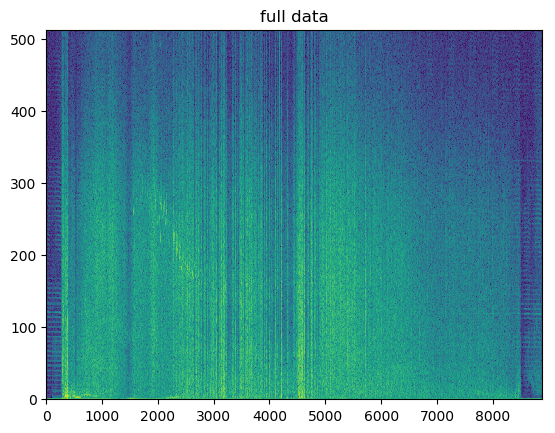

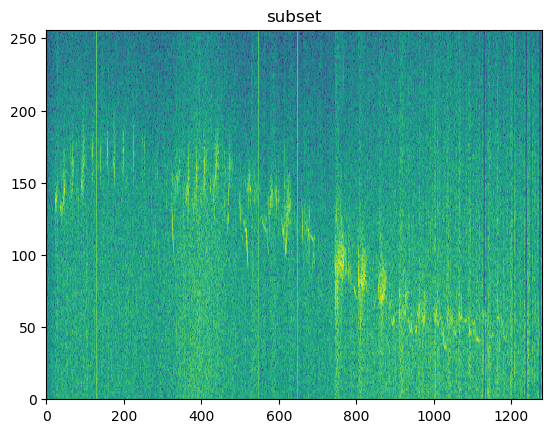

PyObject <matplotlib.collections.QuadMesh object at 0x7fe612377ac8>

In [95]:
testdata = readfun(joinpath(datapath, "Jldata10893.h5"));
pcolormesh(testdata)
title("full data")
subtestdata = testdata[129:384, 1537:2816]
figure()
title("subset")
pcolormesh(subtestdata)

In [96]:
convtestdata = AlfvenDetectors.split_reshape(testdata,patchsize);
println(size(convtestdata))
convsubtestdata = AlfvenDetectors.split_reshape(subtestdata,patchsize);
size(convsubtestdata)

(128, 128, 1, 276)


(128, 128, 1, 20)

In [163]:
#modelpath = "/home/vit/vyzkum/alfven/experiments/conv/uprobe/"
modelpath = "/home/vit/vyzkum/alfven/experiments/conv/uprobe/ae-test"
filenames = readdir(modelpath);
println("$(length(filenames)) models found in modelpath")

19 models found in modelpath


In [164]:
params = [
#    :nepochs => 200
]
fstrings = vcat([""], ["$(x[1])-$(x[2])" for x in params])

1-element Array{String,1}:
 ""

In [165]:
files = joinpath.(modelpath,filter(x->any(map(y->occursin(y,x),fstrings)),filenames));
println("working with a list of $(length(filenames)) files")

working with a list of 19 files


In [166]:
function parse_params(filename::String)
    subss = split(filename, "_")
    params = Dict()
    model = split(subss[1],"/")[end]
    params[:model] = model
    for subs in subss[2:end-1]
        key, val = split(subs, "-")
        try 
            val = eval(Meta.parse(val))
        catch e
            nothing
        end
        params[Symbol(key)] = val
    end
    time = split(subss[end],".bson")[1]
    params[:time] = time
    return params
end

parse_params (generic function with 1 method)

In [167]:
function plothistory(h, val; label=nothing, inds=nothing)
    is,xs = get(h,val)
    if inds == nothing
        inds = 1:length(xs)
    end
    if label==nothing
        plot(is[inds], xs[inds])
    else
        plot(is[inds], xs[inds], label=label)
    end
end
function plotvae(h, inds=nothing)
    plothistory(h,:loss,label="loss",inds=inds)
    plothistory(h,:loglikelihood,label="-loglikelihood",inds=inds)
    plothistory(h,:KL,label="KL",inds=inds)
end
function plotae(h, inds=nothing)
    plothistory(h,:loss,label="loss",inds=inds)
end
function plotloss(h,inds=nothing)
    if :KL in keys(h)
        plotvae(h,inds)
    else
        plotae(h,inds)
    end
end
function plotlosses(h, inds=nothing)
    if length(h) == 1
        figure()
        plotloss(h,inds)
        legend()
    else
        for _h in h
            figure()
            plotloss(_h,inds)
            legend()
        end
    end 
end

plotlosses (generic function with 2 methods)

Lets focus on the AE models that have the lowest loss first.

In [190]:
loss_list = []
model_params_list = []
model_list = []
for imodel in 1:length(files)
    model_data = BSON.load(files[imodel])
    is, ls = get(model_data[:history], :loss)
    push!(loss_list, ls)
    push!(model_params_list, parse_params(files[imodel]))
    push!(model_list, model_data[:model])
end
final_losses = [x[end] for x in loss_list];

Filter out some models

In [191]:
filter_inds = [x[:xdim][1] == 128 for x in model_params_list]
model_params_list = model_params_list[filter_inds]
loss_list = loss_list[filter_inds]
model_list = model_list[filter_inds]
final_losses = final_losses[filter_inds];

In [192]:
valid_loss = []
for model in model_list
    push!(valid_loss, AlfvenDetectors.loss(model, validdata).data)
end

In [170]:
function pretty_params(params)
    s = ""
    for (key, val) in params
        s *= "$key = $val \n"
    end
    return s
end

pretty_params (generic function with 1 method)

In [171]:
testdata = readfun(joinpath(datapath, "Jldata10893.h5"));
subtestdata = testdata[129:384, 1537:2816]
convtestdata = AlfvenDetectors.split_reshape(testdata,patchsize);
convsubtestdata = AlfvenDetectors.split_reshape(subtestdata,patchsize);

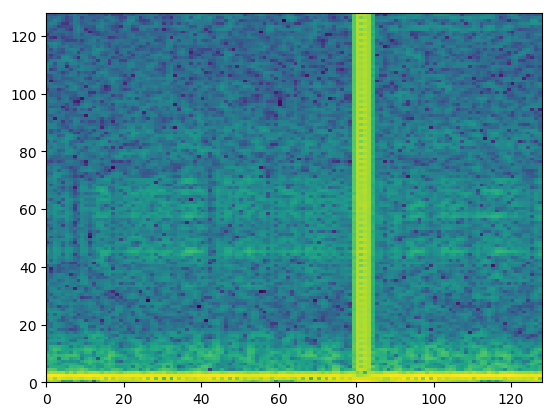

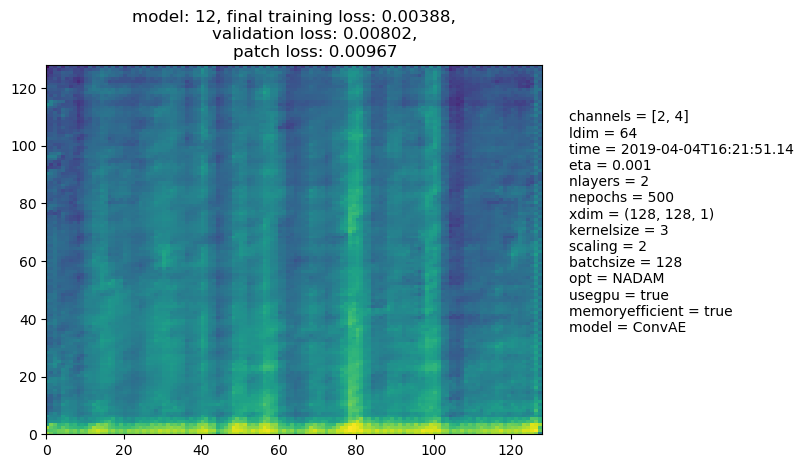

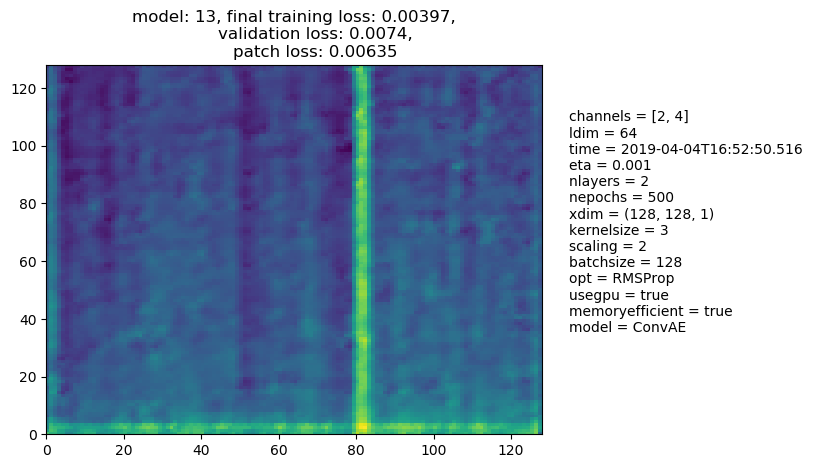

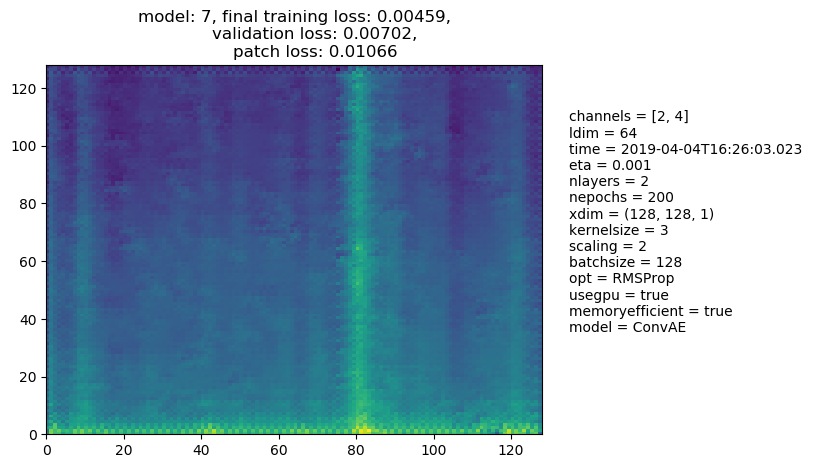

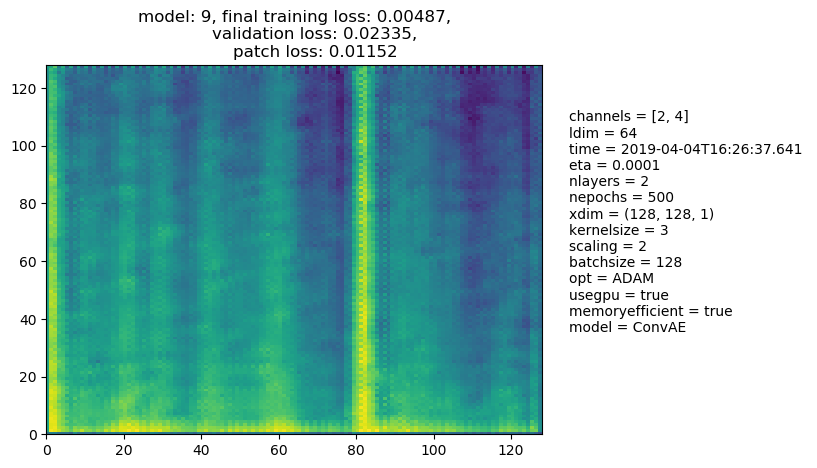

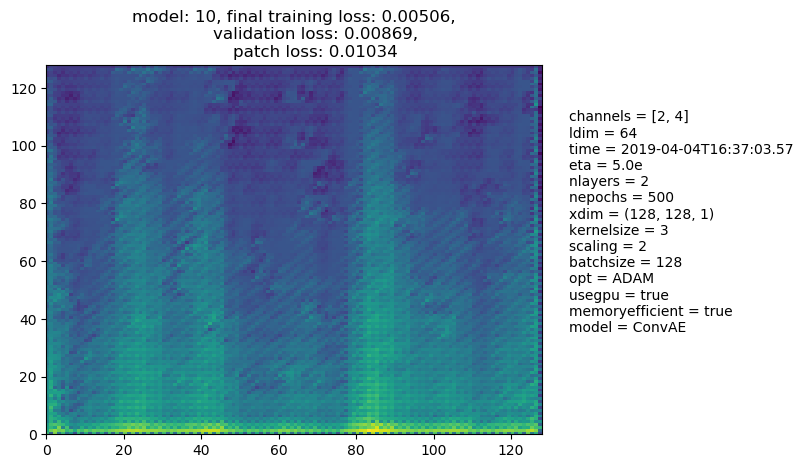

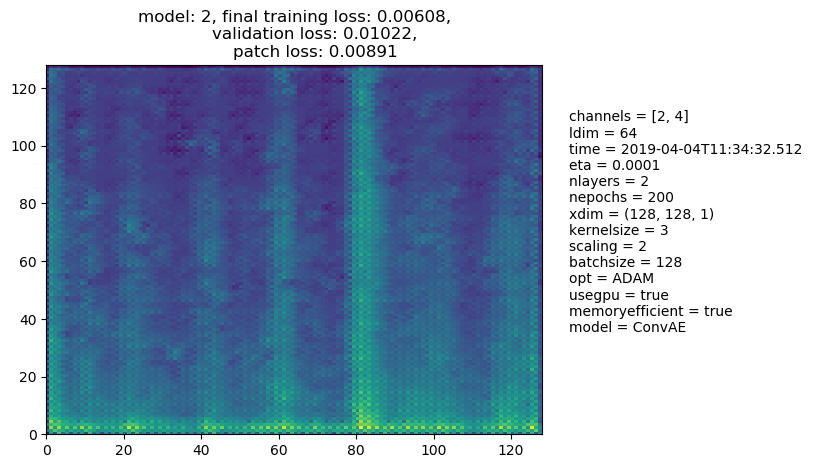

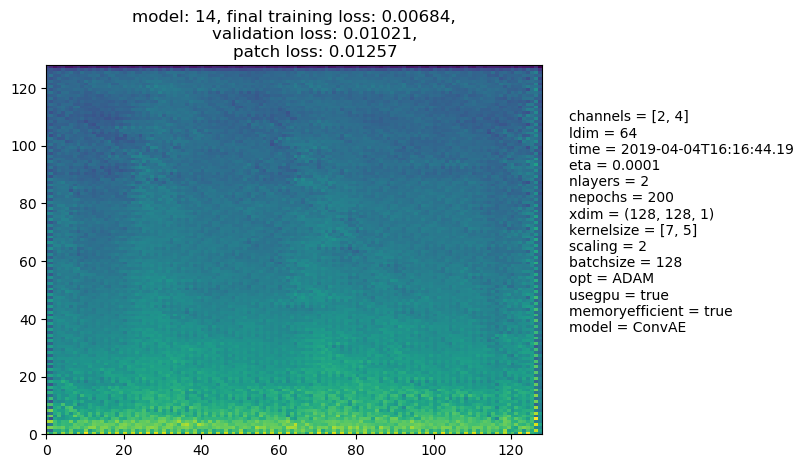

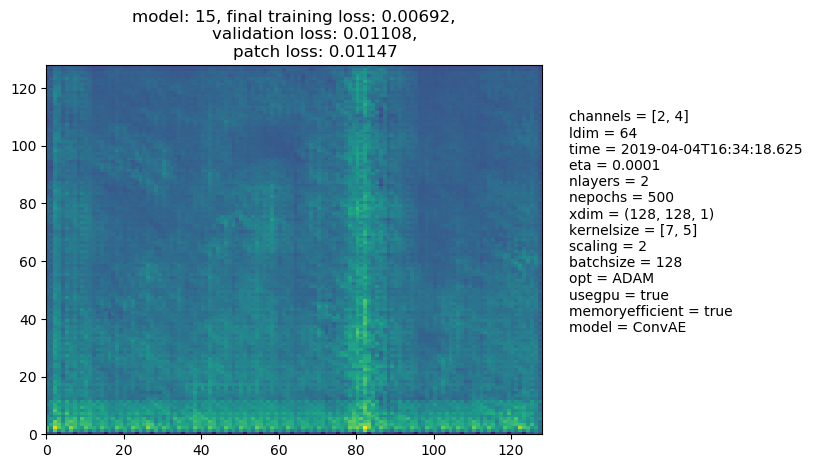

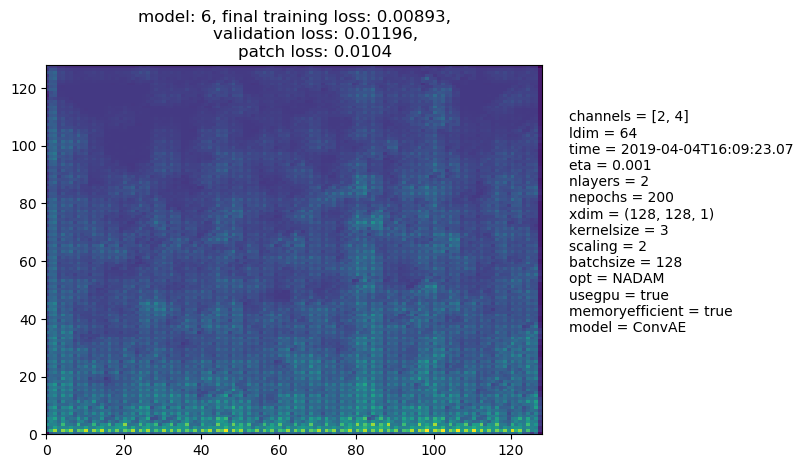

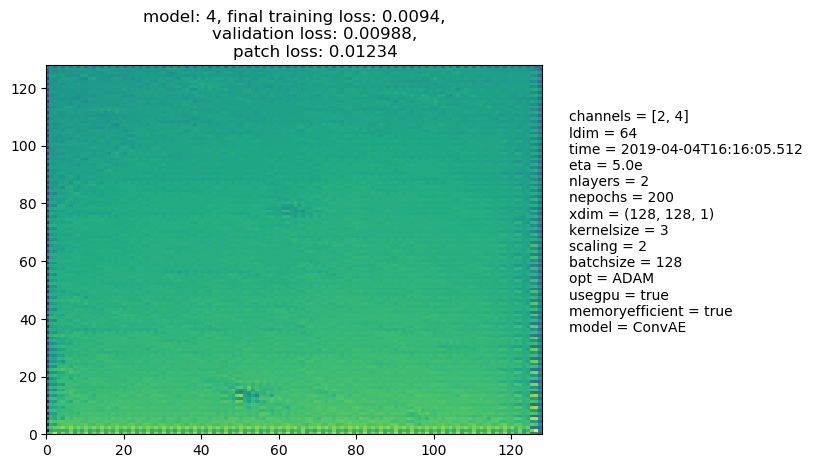

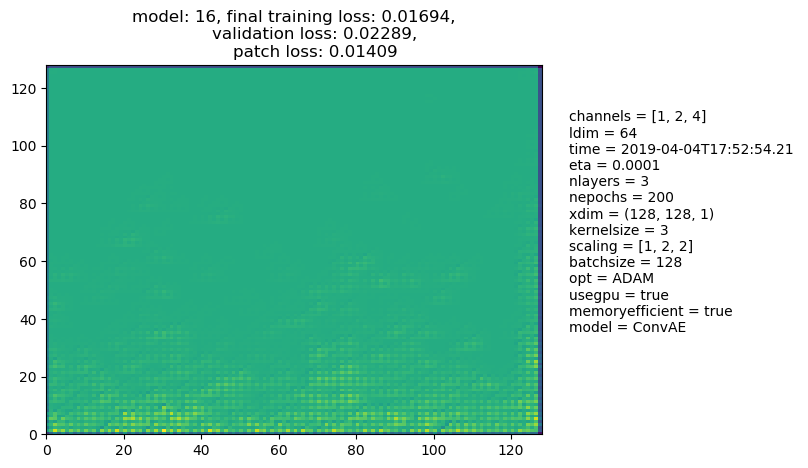

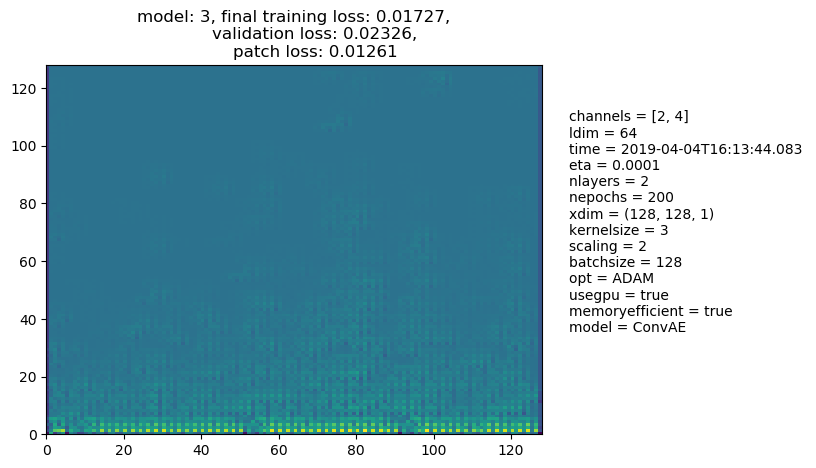

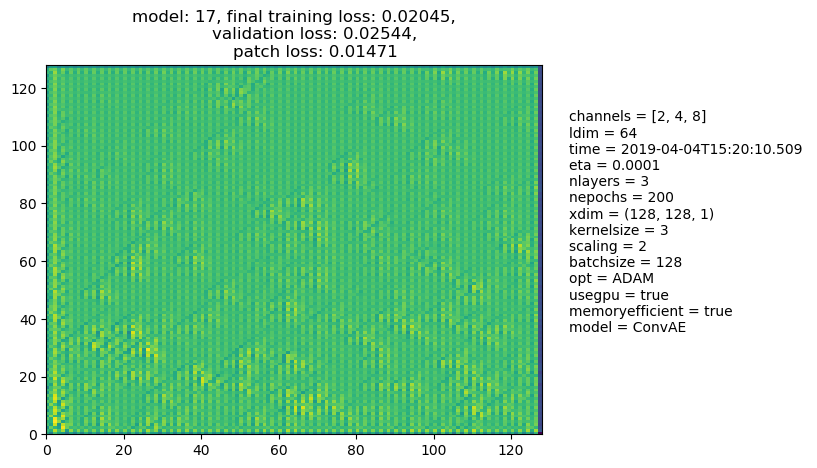

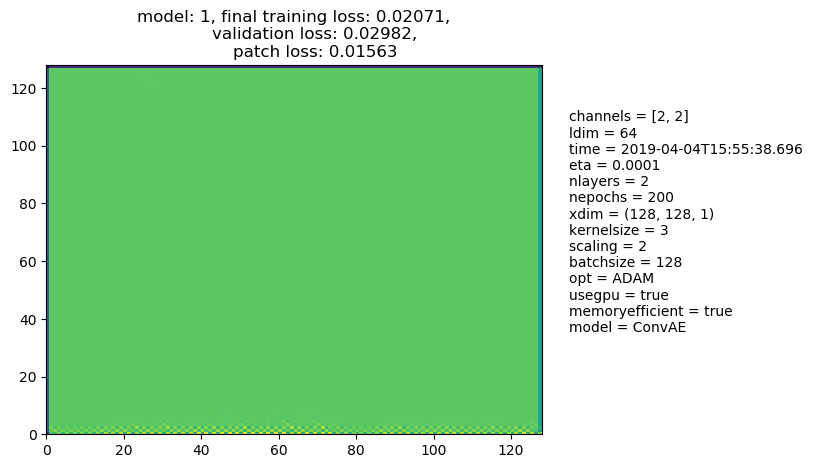

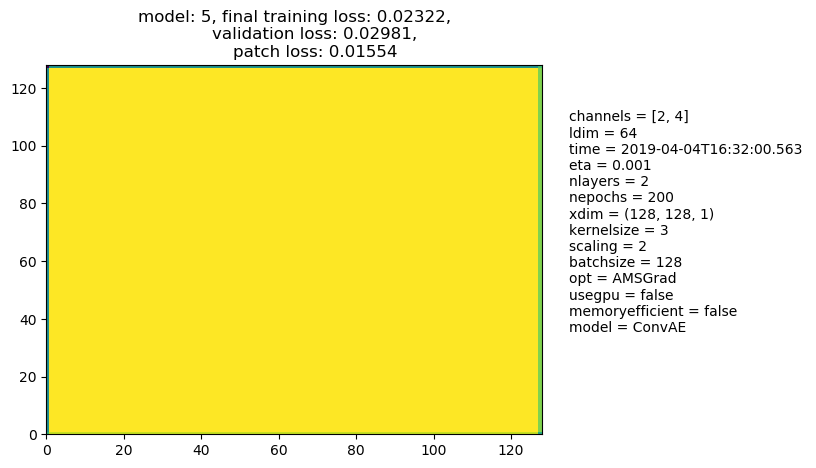

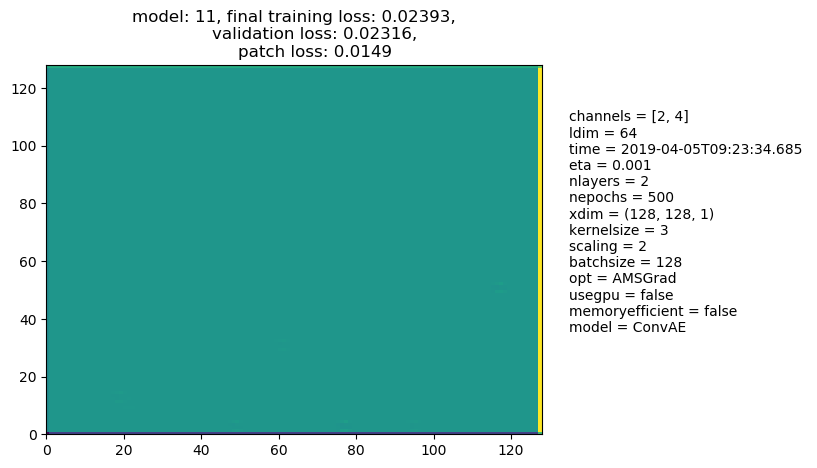

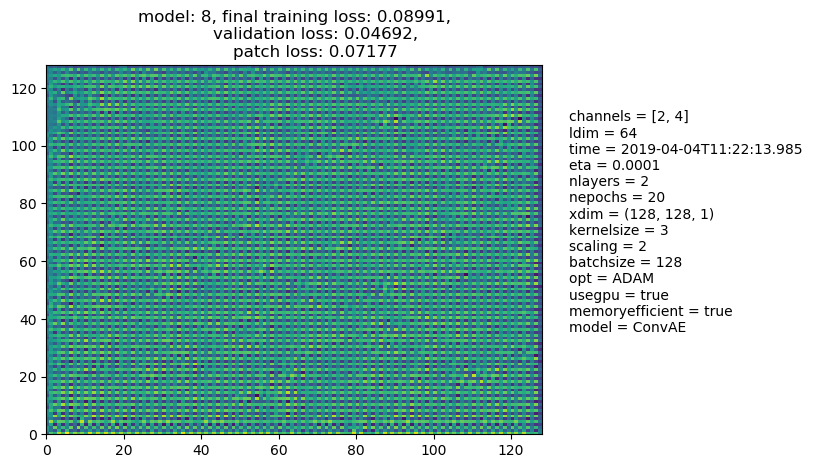

In [209]:
sortinds = sortperm(final_losses);
isample = 201
#sample = data[:,:,:,isample:isample]
#sample = convsubtestdata[:,:,:,isample:isample]
sample = validdata[:,:,:,isample:isample]
pcolormesh(sample[:,:,1,1])
for imodel in sortinds
    figure()
    ns = model_list[imodel](sample).data
    cl = Flux.mse(sample,ns)
    title("model: $imodel, final training loss: $(round(final_losses[imodel],digits=5)),
        validation loss: $(round(valid_loss[imodel],digits=5)),
        patch loss: $(round(cl,digits=5))")
    pcolormesh(ns[:,:,1,1])
    text(135, 30, pretty_params(model_params_list[imodel]))
end

Now lets look at a particular AE model.

In [210]:
imodel = sortinds[2]
model_data = BSON.load(files[imodel])
model = model_data[:model]
hist = model_data[:history]
println(files[imodel])
params = parse_params(files[imodel])

/home/vit/vyzkum/alfven/experiments/conv/uprobe/ae-test/ConvAE_xdim-(128, 128, 1)_ldim-64_nlayers-2_kernelsize-3_channels-[2, 4]_scaling-2_batchsize-128_nepochs-500_opt-RMSProp_eta-0.001_usegpu-true_memoryefficient-true_2019-04-04T16:52:50.516.bson


Dict{Any,Any} with 14 entries:
  :channels        => [2, 4]
  :ldim            => 64
  :time            => "2019-04-04T16:52:50.516"
  :eta             => 0.001
  :nlayers         => 2
  :nepochs         => 500
  :xdim            => (128, 128, 1)
  :kernelsize      => 3
  :scaling         => 2
  :batchsize       => 128
  :opt             => RMSProp
  :usegpu          => true
  :memoryefficient => true
  :model           => "ConvAE"

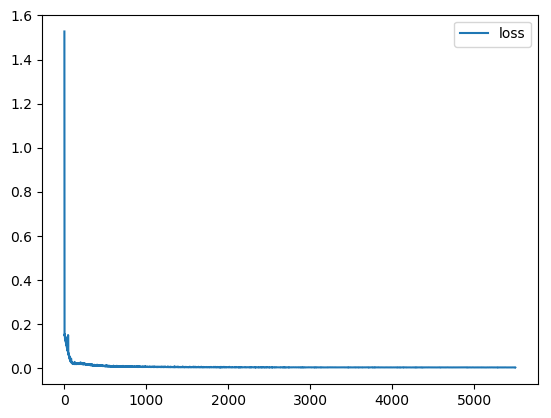

PyObject <matplotlib.legend.Legend object at 0x7fe6061cd240>

In [211]:
plotlosses(hist)

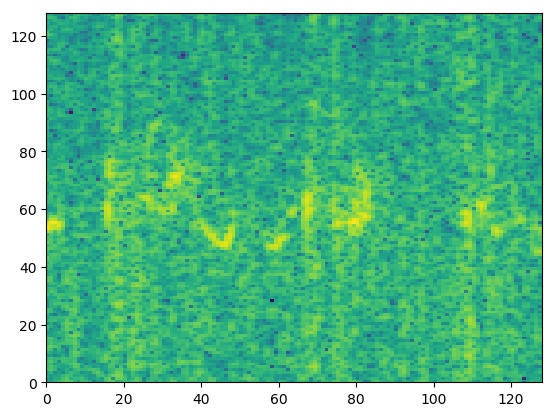

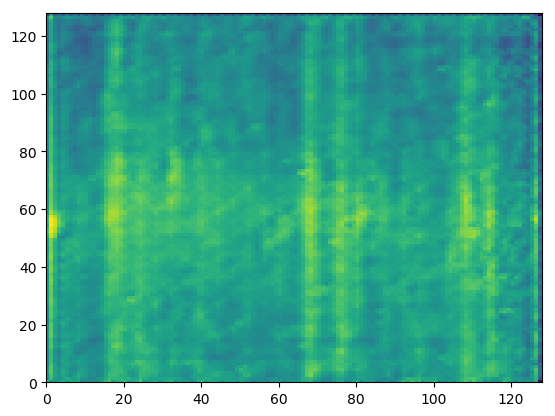

PyObject <matplotlib.collections.QuadMesh object at 0x7fe6068f8898>

In [214]:
i = 15
figure()
pcolormesh(convsubtestdata[:,:,1,i])
sample = convsubtestdata[:,:,1:1,i:i];
figure()
pcolormesh(model(sample).data[:,:,1,1])

In [215]:
using PyCall
umap = pyimport("umap")

PyObject <module 'umap' from '/home/vit/anaconda3/lib/python3.7/site-packages/umap/__init__.py'>

In [216]:
umap_model = umap.UMAP(n_components = 2, n_neighbors=15, min_dist=0.1)

PyObject UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
   metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
   n_neighbors=15, negative_sample_rate=5, random_state=None,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
   transform_seed=42, verbose=False)

In [217]:
size(data)
zdata = []
for i in 1:Int(size(data,4)/10)
    if params[:model] == "ConvTSVAE"
        _zdata = model.m1.encoder(data[:,:,:,(i-1)*10+1:i*10]).data
    else
        _zdata = model.encoder(data[:,:,:,(i-1)*10+1:i*10]).data
    end    
    push!(zdata,_zdata)
end
zdata = hcat(zdata...);
size(zdata)

(64, 1380)

In [218]:
zdata2D = Array(umap_model.fit_transform(zdata')')

2×1380 Array{Float32,2}:
  8.74759    8.65063   8.74909   8.98052   …  4.02079  7.4985    8.66021
 -0.410015  -0.37355  -0.47147  -0.694925     5.3936   2.62843  -0.41266

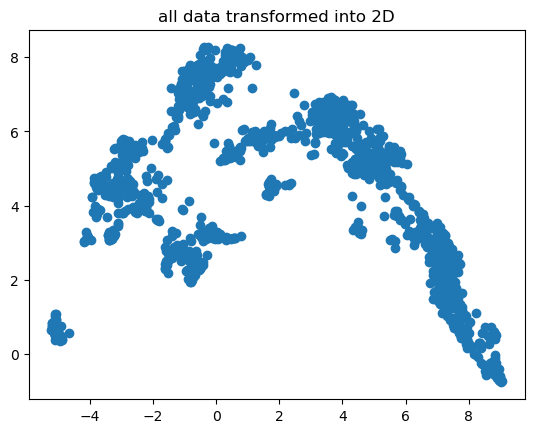

PyObject Text(0.5, 1.0, 'all data transformed into 2D')

In [219]:
scatter(zdata2D[1,:], zdata2D[2,:])
title("all data transformed into 2D")

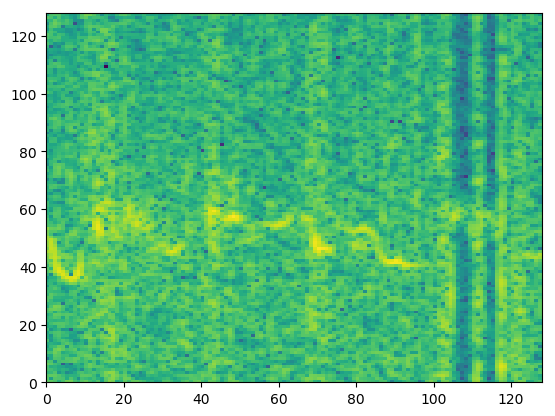

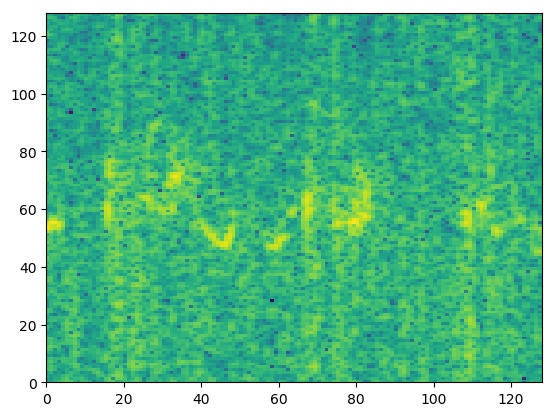

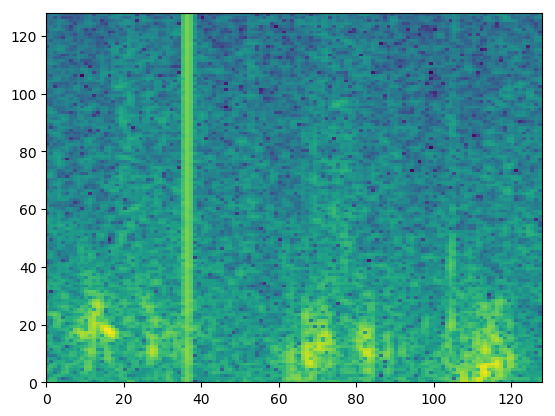

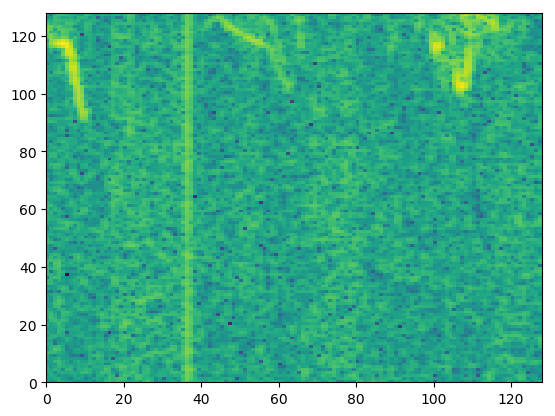

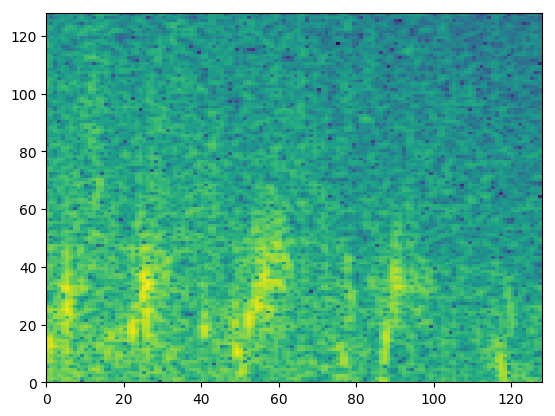

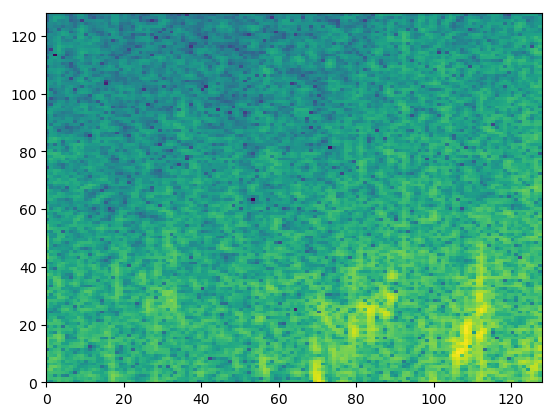

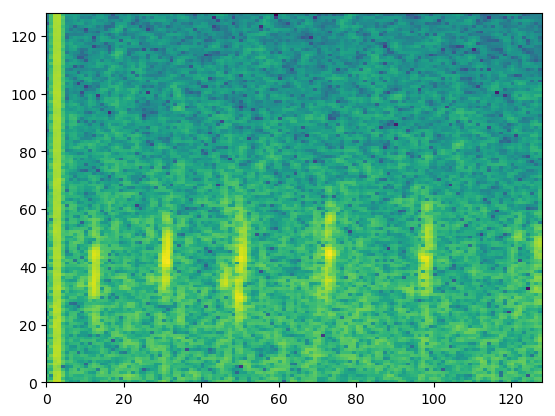

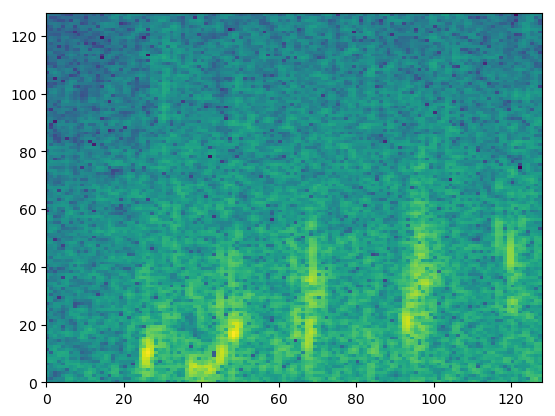

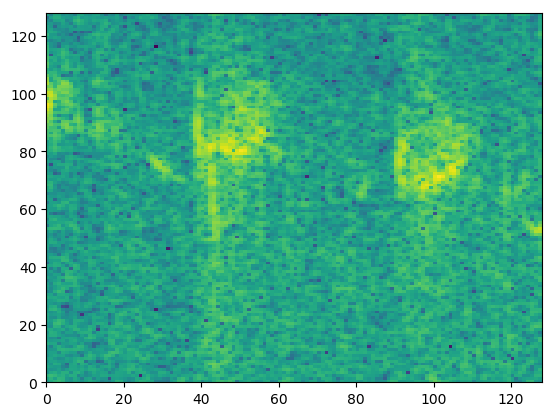

In [224]:
selectinds = [17,15,10,9,8,6,4,2,13]
#selectinds = [17,15,9,13]
chirpdata = convsubtestdata[:,:,:,selectinds]
for i in 1:length(selectinds)
   figure()
    pcolormesh(chirpdata[:,:,1,i])
end

In [225]:
if params[:model] == "ConvTSVAE"
    chirpzdata = model.m1.encoder(chirpdata).data
else
    chirpzdata = model.encoder(chirpdata).data
end
chirpzdata2D = Array(umap_model.transform(chirpzdata')')

2×9 Array{Float32,2}:
 -3.58777  -3.87098  1.7878   -2.69932  …  0.621503  1.00754  -3.8282 
  4.73854   4.63066  5.80131   5.14493     5.41463   5.87913   4.78891

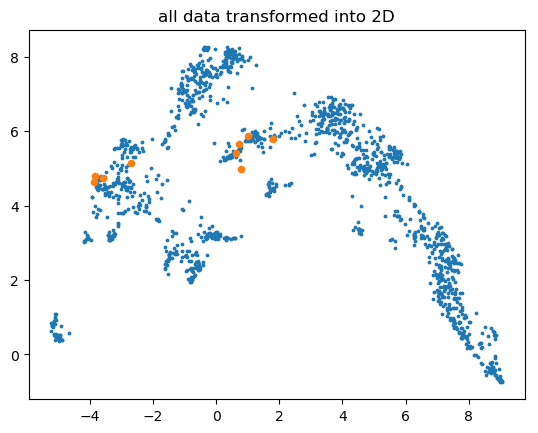

PyObject Text(0.5, 1.0, 'all data transformed into 2D')

In [226]:
scatter(zdata2D[1,:], zdata2D[2,:],s=3)
scatter(chirpzdata2D[1,:], chirpzdata2D[2,:],s=20)
title("all data transformed into 2D")

Find some shots with chirp modes and use them as validation data.

In [ ]:
#lims = [6.5 8.3; 0.0 2.1]
lims = [6.5 8.3; 0.0 2.1]
box = [lims[1,1] lims[1,2] lims[1,2] lims[1,1] lims[1,1]; lims[2,1] lims[2,1] lims[2,2] lims[2,2] lims[2,1]]

Instead of boxes, search for N nearest samples in the original latent space.

In [ ]:
clusterinds = (lims[:,1] .<= zdata2D .<= lims[:,2]);
clusterinds = clusterinds[1,:] .& clusterinds[2,:];

In [ ]:
scatter(zdata2D[1,:], zdata2D[2,:],s=3)
scatter(zdata2D[1,clusterinds], zdata2D[2,clusterinds],s=3)
plot(box[1,:], box[2,:],c="k")

In [ ]:
clusterconvdata = data[:,:,:,clusterinds];
size(clusterconvdata)

In [ ]:
for i in 1:size(clusterconvdata,4)
    figure()
    pcolormesh(clusterconvdata[:,:,1,i])
end

In [ ]:
model.m1.encoder

In [ ]:
#sample = batch[:,:,1:1,2:2]
sample = chirpdata[:,:,:,2:2]
m = model.m1.encoder.layers[1].layers[1](sample)
#m = model.m1.encoder.layers[1].layers[2](model.m1.encoder.layers[1].layers[1](sample))

In [ ]:
pcolormesh(sample[:,:,1,1])

In [ ]:
for i in 1:size(m,3)
    figure()
    pcolormesh(m.data[:,:,i,1])
end

Now test a selected model

In [112]:
modelpath = "/home/vit/vyzkum/alfven/experiments/conv/uprobe/"
filenames = readdir(modelpath)
params = [
#    :nepochs => 200
    :opt => "NADAM"
]
fstrings = vcat(["$(x[1])-$(x[2])" for x in params])
filenames = joinpath.(modelpath,filter(x->any(map(y->occursin(y,x),fstrings)),filenames));
println("working with a list of $(length(filenames)) files")

working with a list of 2 files


In [115]:
filename = filenames[2]
model_data = BSON.load(filename)
model = model_data[:model]
hist = model_data[:history]
params = parse_params(filename)

Dict{Any,Any} with 15 entries:
  :channels        => [2, 4]
  :ldim            => 64
  :time            => "2019-04-05T10:51:44.531"
  :eta             => 0.001
  :variant         => "scalar"
  :nlayers         => 2
  :nepochs         => 1000
  :xdim            => (128, 128, 1)
  :kernelsize      => 3
  :scaling         => 2
  :batchsize       => 128
  :opt             => NADAM
  :usegpu          => true
  :memoryefficient => true
  :model           => "ConvVAE"

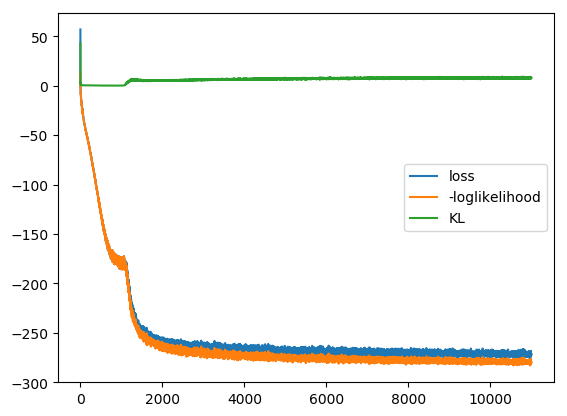

PyObject <matplotlib.legend.Legend object at 0x7fe611dcab38>

In [116]:
plotlosses(hist)

In [159]:
filename

"/home/vit/vyzkum/alfven/experiments/conv/uprobe/ConvVAE_xdim-(128, 128, 1)_ldim-64_nlayers-2_kernelsize-3_channels-[2, 4]_scaling-2_variant-scalar_batchsize-128_nepochs-1000_opt-NADAM_eta-0.001_usegpu-true_memoryefficient-true_2019-04-05T10:51:44.531.bson"

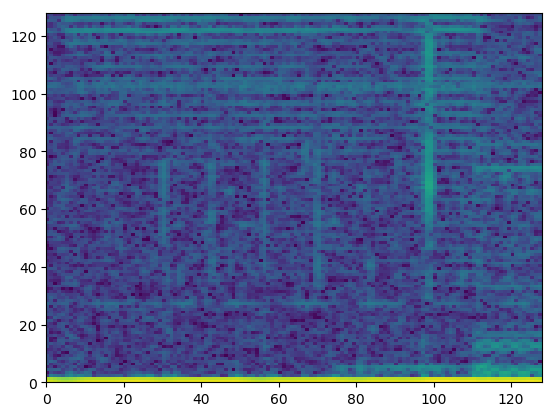

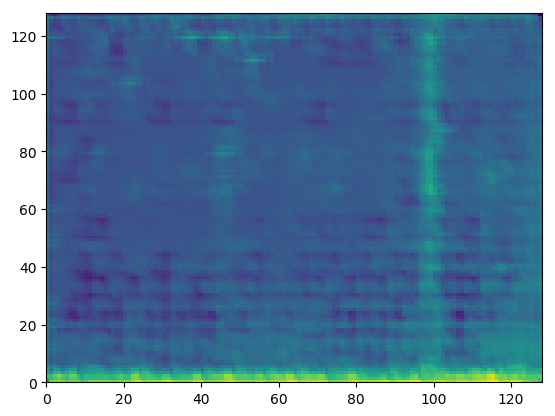

PyObject <matplotlib.collections.QuadMesh object at 0x7fe6071fe8d0>

In [158]:
isample = 1
#sample = convsubtestdata[:,:,:,isample:isample]
sample = data[:,:,:,isample:isample]
pcolormesh(sample[:,:,1,1])
ns = model(sample).data
figure()
pcolormesh(ns[:,:,1,1])